In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
import math
import matplotlib.gridspec as gridspec
from plotting import newfig
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import layers, activations
from scipy.interpolate import griddata
from eager_lbfgs import lbfgs, Struct
from pyDOE import lhs

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [3]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from matplotlib.ticker import AutoMinorLocator,MultipleLocator,FuncFormatter
import matplotlib.ticker as ticker

In [4]:
import random
random_seed = 1236
random.seed(random_seed )  # set random seed for python
np.random.seed(random_seed )  # set random seed for numpy
tf.random.set_seed(random_seed )  # set random seed for tensorflow-cpu

In [5]:
layer_sizes = [2, 50, 50, 50, 50, 1]

sizes_w = []
sizes_b = []
for i, width in enumerate(layer_sizes):
    if i != 1:
        sizes_w.append(int(width * layer_sizes[1]))
        sizes_b.append(int(width if i != 0 else layer_sizes[1]))

def set_weights(model, w, sizes_w, sizes_b):
        for i, layer in enumerate(model.layers[0:]):
            start_weights = sum(sizes_w[:i]) + sum(sizes_b[:i])
            end_weights = sum(sizes_w[:i+1]) + sum(sizes_b[:i])
            weights = w[start_weights:end_weights]
            w_div = int(sizes_w[i] / sizes_b[i])
            weights = tf.reshape(weights, [w_div, sizes_b[i]])
            biases = w[end_weights:end_weights + sizes_b[i]]
            weights_biases = [weights, biases]
            layer.set_weights(weights_biases)

def get_weights(model):
    w = []
    for layer in model.layers[0:]:
        weights_biases = layer.get_weights()
        weights = weights_biases[0].flatten()
        biases = weights_biases[1]
        w.extend(weights)
        w.extend(biases)

    w = tf.convert_to_tensor(w)
    return w

def neural_net(layer_sizes):
    model = Sequential()
    model.add(layers.InputLayer(input_shape=(layer_sizes[0],)))
    for width in layer_sizes[1:-1]:
        model.add(layers.Dense(
            width, activation=tf.nn.tanh,
            kernel_initializer="glorot_normal"))
    model.add(layers.Dense(
            layer_sizes[-1], activation=None,
            kernel_initializer="glorot_normal"))
    return model


u_model = neural_net(layer_sizes)


def loss(x_f, y_f,
         x_lb, y_lb,
         x_ub, y_ub,
         x_rb, y_rb,
         x_lftb, ylftb,
         col_weights):

    f_u_pred = f_model(x_f, y_f)

    u_lb_pred = u_model(tf.concat([x_lb, y_lb],1))
    u_ub_pred = u_model(tf.concat([x_ub, y_ub],1))
    u_rb_pred = u_model(tf.concat([x_rb, y_rb],1))
    u_lftb_pred = u_model(tf.concat([x_lftb, y_lftb],1))

    mse_b_u = tf.reduce_mean(tf.square(u_lb_pred - 0)) + \
            tf.reduce_mean(tf.square(u_ub_pred - 0)) + \
            tf.reduce_mean(tf.square(u_rb_pred - 0)) + \
            tf.reduce_mean(tf.square(u_lftb_pred - 0))
    #
    mse_f_u = tf.reduce_mean(tf.square(col_weights*f_u_pred))

    return  mse_b_u + mse_f_u , mse_b_u, mse_f_u

def f_model(x, y):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            tape.watch(y)

            u = u_model(tf.concat([x, y],1))


            u_x = tape.gradient(u, x)
            u_y = tape.gradient(u, y)

        u_xx = tape.gradient(u_x, x)

        u_yy = tape.gradient(u_y, y)

        del tape
        a1 = 1.0
        a2 = 8.0
        ksq = 1.0
        forcing = - (a1*math.pi)**2*np.sin(a1*math.pi*x)*np.sin(a2*math.pi*y) - \
                    (a2*math.pi)**2*np.sin(a1*math.pi*x)*np.sin(a2*math.pi*y) + \
                    ksq*np.sin(a1*math.pi*x)*np.sin(a2*math.pi*y)

        f_u = u_xx + u_yy + ksq*u - forcing

        return f_u

def fit(x_f, t_f, x_lb, y_lb, x_ub, y_ub, x_rb, y_rb, x_lftb, y_lftb, col_weights, tf_iter, newton_iter):

    batch_sz = N_f
    n_batches =  N_f // batch_sz
    start_time = time.time()
    tf_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1=.99)
    tf_optimizer_coll = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1=.99)

    print("starting Adam training")
    for epoch in range(tf_iter):
        for i in range(n_batches):

            x_f_batch = x_f[i*batch_sz:(i*batch_sz + batch_sz),]
            y_f_batch = y_f[i*batch_sz:(i*batch_sz + batch_sz),]

            with tf.GradientTape(persistent=True) as tape:
                loss_value, mse_b, mse_f = loss(x_f, y_f, x_lb, y_lb, x_ub, y_ub, x_rb, y_rb, x_lftb, y_lftb, col_weights)
                grads = tape.gradient(loss_value, u_model.trainable_variables)
                grads_col = tape.gradient(loss_value, col_weights)
            tf_optimizer.apply_gradients(zip(grads, u_model.trainable_variables))
            tf_optimizer_coll.apply_gradients(zip([-grads_col], [col_weights]))


            del tape

            if  epoch % 100 == 0:
                elapsed = time.time() - start_time
                print('It: %d, Time: %.2f' % (epoch, elapsed))
                tf.print(f"mse_b: {mse_b}  mse_f: {mse_f}   total loss: {loss_value}")
                start_time = time.time()


    print("Starting L-BFGS training")

    loss_and_flat_grad = get_loss_and_flat_grad(x_f, y_f, x_lb, y_lb, x_ub, y_ub, x_rb, y_rb, x_lftb, y_lftb, col_weights)

    lbfgs(loss_and_flat_grad,
      get_weights(u_model),
      Struct(), maxIter=newton_iter, learningRate=0.8)

def get_loss_and_flat_grad(x_f, y_f, x_lb, y_lb, x_ub, y_ub, x_rb, y_rb, x_lftb, y_lftb, col_weights):
    def loss_and_flat_grad(w):
        with tf.GradientTape() as tape:
            set_weights(u_model, w, sizes_w, sizes_b)
            loss_value, _, _ = loss(x_f, y_f, x_lb, y_lb, x_ub, y_ub, x_rb, y_rb, x_lftb, y_lftb, col_weights)
        grad = tape.gradient(loss_value, u_model.trainable_variables)
        grad_flat = []
        for g in grad:
            grad_flat.append(tf.reshape(g, [-1]))
        grad_flat = tf.concat(grad_flat, 0)
        #print(loss_value, grad_flat)
        return loss_value, grad_flat

    return loss_and_flat_grad


def predict(X_star):
    X_star = tf.convert_to_tensor(X_star, dtype=tf.float32)
    u_star = u_model(X_star)

    f_u_star = f_model(X_star[:,0:1],
                 X_star[:,1:2])

    return u_star.numpy(), f_u_star.numpy()

In [6]:
lb = np.array([-1.0])
ub = np.array([1.0])
rb = np.array([1.0])
lftb = np.array([-1.0])

N0 = 1200
N_b = 1200 #25 per upper and lower boundary, so 50 total
N_f = 10000

col_weights = tf.Variable(tf.random.uniform([N_f, 1]))
u_weights = tf.Variable(100*tf.random.uniform([N0, 1]))


nx, ny = (1200,1200)
x = np.linspace(-1, 1, nx)
y = np.linspace(-1, 1, ny)


xv, yv = np.meshgrid(x,y)

x = np.reshape(x, (-1,1))
y = np.reshape(y, (-1,1))


Exact_u = np.sin(math.pi*xv)*np.sin(8*math.pi*yv)


idx_x = np.random.choice(x.shape[0], N0, replace=False)
x0 = x[idx_x,:]
u0 = Exact_u[idx_x,0:1]

idx_y = np.random.choice(y.shape[0], N_b, replace=False)
yb = y[idx_y, :]



X_f = lb + (ub-lb)*lhs(2, N_f)

x_f = tf.convert_to_tensor(X_f[:,0:1], dtype=tf.float32)
y_f = tf.convert_to_tensor(X_f[:,1:2], dtype=tf.float32)


X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
X_lb = np.concatenate(( yb, 0*yb + lb[0]), 1) # lower boundary (x, -1)
X_ub = np.concatenate(( yb, 0*yb + ub[0]), 1)  # upper boundary (x, 1)
X_rb = np.concatenate((0*yb + rb[0], yb), 1) # right boundary (1, y)
X_lftb = np.concatenate((0*yb + lftb[0], yb), 1) # left boundary (-1,y)


x0 = X0[:,0:1]
y0 = X0[:,1:2]

x_lb = tf.convert_to_tensor(X_lb[:,0:1], dtype=tf.float32)
y_lb = tf.convert_to_tensor(X_lb[:,1:2], dtype=tf.float32)

x_ub = tf.convert_to_tensor(X_ub[:,0:1], dtype=tf.float32)
y_ub = tf.convert_to_tensor(X_ub[:,1:2], dtype=tf.float32)

x_rb = tf.convert_to_tensor(X_rb[:,0:1], dtype=tf.float32)
y_rb = tf.convert_to_tensor(X_rb[:,1:2], dtype=tf.float32)

x_lftb = tf.convert_to_tensor(X_lftb[:,0:1], dtype=tf.float32)
y_lftb = tf.convert_to_tensor(X_lftb[:,1:2], dtype=tf.float32)

In [7]:
fit(x_f, y_f, x_lb, y_lb, x_ub, y_ub, x_rb, y_rb, x_lftb, y_lftb, col_weights,
    tf_iter = 2000, newton_iter = 40000)

starting Adam training
It: 0, Time: 0.41
mse_b: 0.032895393669605255  mse_f: 35291.8203125   total loss: 35291.8515625
It: 100, Time: 49.19
mse_b: 13.720444679260254  mse_f: 46523.8046875   total loss: 46537.5234375
It: 200, Time: 81.43
mse_b: 44.4859504699707  mse_f: 59971.46875   total loss: 60015.953125
It: 300, Time: 80.06
mse_b: 67.91084289550781  mse_f: 74782.640625   total loss: 74850.5546875
It: 400, Time: 80.76
mse_b: 113.49114990234375  mse_f: 76402.1484375   total loss: 76515.640625
It: 500, Time: 81.98
mse_b: 63.288570404052734  mse_f: 75314.484375   total loss: 75377.7734375
It: 600, Time: 79.48
mse_b: 94.62028503417969  mse_f: 69299.625   total loss: 69394.2421875
It: 700, Time: 79.75
mse_b: 182.6741943359375  mse_f: 47430.09765625   total loss: 47612.7734375
It: 800, Time: 80.50
mse_b: 270.5950622558594  mse_f: 25450.59765625   total loss: 25721.193359375
It: 900, Time: 81.21
mse_b: 342.417236328125  mse_f: 11328.568359375   total loss: 11670.9853515625
It: 1000, Time: 8

In [8]:
#generate mesh for plotting
X, Y = np.meshgrid(x,y)

X_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
u_star = Exact_u.flatten()[:,None]


lb = np.array([-1.0, -1.0])
ub = np.array([1.0, 1])

u_pred, f_u_pred = predict(X_star)


error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)

print('Error u: %e' % (error_u))

Error u: 6.050176e-03


In [9]:

U_pred = griddata(X_star, u_pred.flatten(), (X, Y), method='cubic')


FU_pred = griddata(X_star, f_u_pred.flatten(), (X, Y), method='cubic')

No handles with labels found to put in legend.


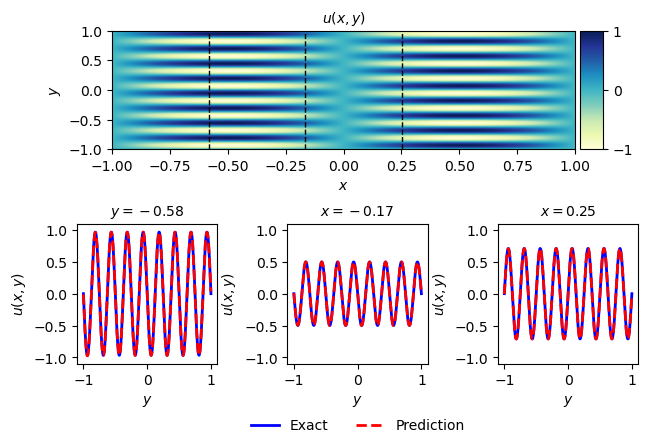

In [10]:
fig, ax = newfig(1.3, 1.0)
ax.axis('off')

####### Row 0: h(t,x) ##################
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred, interpolation='nearest', cmap='YlGnBu',
              extent=[lb[1], ub[1], lb[0], ub[0]],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)


line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(y[250]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(y[500]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(y[750]*np.ones((2,1)), line, 'k--', linewidth = 1)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
leg = ax.legend(frameon=False, loc = 'best')

ax.set_title('$u(x,y)$', fontsize = 10)

####### Row 1: h(t,x) slices ##################
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact_u[:,250], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,U_pred[:,250], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$y$')
ax.set_ylabel('$u(x,y)$')
ax.set_title('$y = %.2f$' % (y[250]), fontsize = 10)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact_u[:,500], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,U_pred[:,500], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$y$')
ax.set_ylabel('$u(x,y)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$x = %.2f$' % (y[500]), fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact_u[:,750], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,U_pred[:,750], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$y$')
ax.set_ylabel('$u(x,y)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$x = %.2f$' % (y[750]), fontsize = 10)
plt.show() 

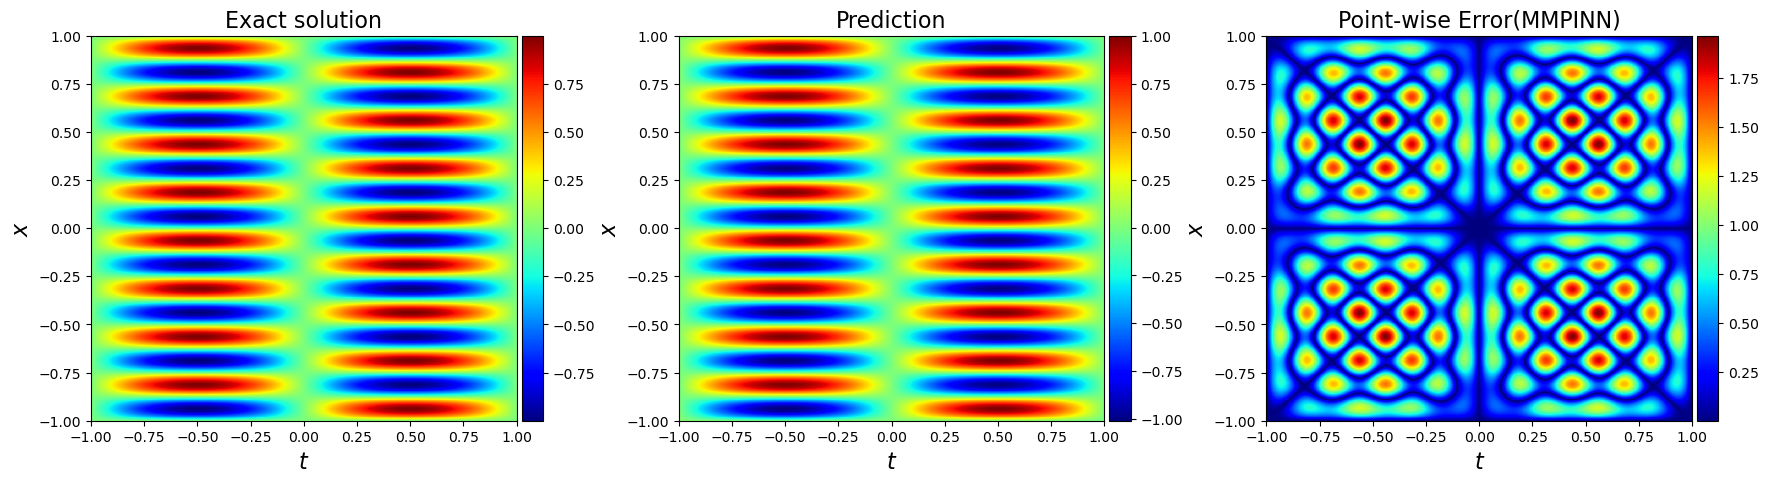

In [17]:
    from matplotlib.colors import LogNorm
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    fig.subplots_adjust(wspace=0.3)  # 调整子图之间的水平间距

    # 第一个子图
    ax1 = axs[0]    
    h = ax1.imshow(Exact_u, interpolation='nearest', cmap='jet', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
    ax1.set_title('Exact solution', fontsize=16)
    ax1.set_xlabel('$t$', fontsize=16)
    ax1.set_ylabel('$x$', fontsize=16)
    #左边的色差图
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    
    ax2 = axs[1]    
    h = ax2.imshow(U_pred, interpolation='nearest', cmap='jet', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
    ax2.set_title('Prediction', fontsize=16)
    ax2.set_xlabel('$t$', fontsize=16)
    ax2.set_ylabel('$x$', fontsize=16)
    #左边的色差图
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    
    ax3 = axs[2]    
    h = ax3.imshow(np.abs(U_pred.T-Exact_u), interpolation='nearest', cmap='jet', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
    ax3.set_title(r'Point-wise Error(MMPINN)', fontsize=16 )
    ax3.set_xlabel('$t$', fontsize=16)
    ax3.set_ylabel('$x$', fontsize=16)
    #左边的色差图
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)    
    
    
    #plt.savefig('Waterasdes.jpg', dpi=500, bbox_inches='tight') # 解决图片不清晰，不完整的问题
    #plt.savefig('0.15 exact solution and point wise error by mmpinn and standard.pdf', bbox_inches='tight') 
    plt.show() 

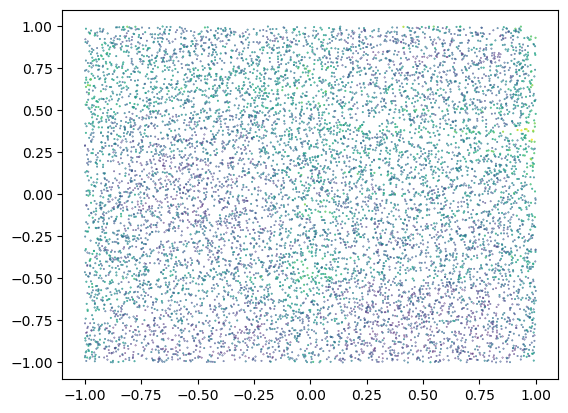

In [15]:
# print collocation point weights
plt.scatter(x_f, y_f, c = col_weights.numpy(), s = col_weights.numpy()/10)
plt.show()


In [13]:
scipy.io.savemat("1.mat", {'u': u_pred}) 